# Position Estimation in a Grid World Using the Bayes Filter


This live script illustrates the use of the Bayes' filter for estimating the 
position of an agent. The agent navigates in a grid world with 77 positions, 
where it will be visible, but also throught addional 40 obstacle positions where 
it will be invisible. The environment is shown in the figure below. The agent 
can only move to an adjacent cell (left, right, up down, while diagonal moves 
are not allowed) at each time step/iteration $k \in \{1, 2, \ldots\}$ or stay 
in the same cell. The agent can only not navigate through the walls, e.g., at 
position 62 it can move up, down, left and right, but at position 5 it can only 
move up, right and left. 

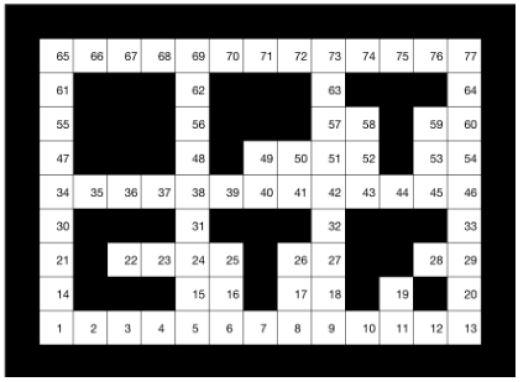

Assume that at every time step the agent has the same probability of staying 
in the same position as that of moving to any other feasible position (not a 
wall). If at a given position the agent is visible, a measurement at time $k$ 
is available:

$$y_{k}=p_{k}=\left[\begin{array}{ll}x_{k} & z_{k}\end{array}\right]$$

where $x_{k} \in\{1, \ldots, 9\}$ is the x coordinate and $z_{k} \in\{1, \ldots, 
13\}$ is the z coordinate at time k, as presented in the figure below. If the 
agent is hidden behind one of the obstacles, no measurement is received and 
this is indicated by

$$y=\left[\begin{array}{ll}-1 & -1\end{array}\right].$$

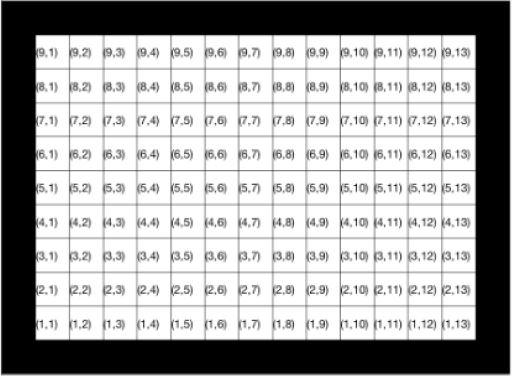

Let $M_{k} \in \mathbb{R}^{9 \times 13}$ be a matrix at time step k with entries

$$\left[M_{k}\right]_{i j}=\text{Prob}\left[p_{k}=[i \quad j] | y_{0}, \ldots, 
y_{k}\right]$$ 

This live script provides $\left[M_{k}\right]_{i j}$ given $\left[M_{k-1}\right]_{i 
j}$ and $y_{k}$, where without loss of generality it can be assumed that $k=1$.

The Matlab function `estimatepacmanpos` below, computes as $\left[M_{k}\right]_{i 
j}$ given the input $\left[M_{k-1}\right]_{i j}$ and the measurent, and its 
use can be illustrated by running the following instruction

In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.sparse as sp
import random
%matplotlib inline

The next function returns a binary matrix with the same dimension of the matrix States with ones at positions where States if infinity and zeros in the other positions.

In [ ]:
def getMask():

    nx = 9
    nz = 13
    M = np.zeros((nx,nz))

    States = [[ 1, 2,3,4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            [14, np.Inf, np.Inf, np.Inf, 15, 16, np.Inf, 17, 18, np.Inf, 19, np.Inf, 20],
            [21, np.Inf, 22, 23,24,25,  np.Inf, 26, 27, np.Inf, np.Inf, 28,  29],
            [30, np.Inf, np.Inf, np.Inf, 31, np.Inf, np.Inf, np.Inf, 32, np.Inf, np.Inf, np.Inf, 33],
            [34, 35, 36, 37,38,39,  40,  41, 42, 43,  44, 45,  46],
            [47, np.Inf, np.Inf, np.Inf, 48, np.Inf,  49, 50, 51, 52, np.Inf, 53,  54],
            [55, np.Inf, np.Inf, np.Inf, 56, np.Inf, np.Inf, np.Inf, 57, 58, np.Inf, 59,  60],
            [61, np.Inf, np.Inf, np.Inf, 62, np.Inf, np.Inf, np.Inf, 63, np.Inf, np.Inf, np.Inf, 64],
            [65, 66, 67, 68,69,70,   71,  72, 73,  74,  75, 76,  77]]
    M[np.array(States)==np.Inf] = 1
    return M

In [ ]:
def estimatepacmanpos(Mcurrent, y, P, Mask):

    nx = 9
    nz = 13

    # Obtain P matrix
    if np.linalg.norm(np.array(y) - np.array([[-1], [-1]])) == 0: # no measure
        
        Mnextvec_ = Mask[:].reshape(117,1)*[P * Mcurrent.reshape(117,1)]
        
        if np.sum(Mnextvec_) == 0:
            print('here')
        
        Mnextvec_ = Mnextvec_/np.sum(Mnextvec_)
        Mnext  = Mnextvec_.reshape(nx,nz)
    else:
        Mnext = np.zeros((nx,nz))
        Mnext[y[0][0],y[1][0]] = 1

    return P, Mask, Mnext

The next function determines the probability transition matrix of the Markov process which is needed for the Bayes filter.

In [ ]:
def getP():
    nx = 9
    nz = 13
    P = sp.csr_matrix(np.zeros((nx*nz,nx*nz)))
    ind = 0
    for indz in range(nz):
        for indx in range(nx):
            jP = xz2ind(indx,indz,nz)
            if indz == 0:
                if indx == 0:
                    P[xz2ind(indx,indz,nz),jP] = 1/3
                    P[xz2ind(indx+1,indz,nz),jP] = 1/3
                    P[xz2ind(indx,indz+1,nz),jP] = 1/3
                else:
                    if indx == nx-1:
                        P[xz2ind(indx,indz,nz),jP] = 1/3
                        P[xz2ind(indx-1,indz,nz),jP] = 1/3
                        P[xz2ind(indx,indz+1,nz),jP] = 1/3
                    else:
                        P[xz2ind(indx,indz,nz),jP] = 1/4
                        P[xz2ind(indx-1,indz,nz),jP] = 1/4
                        P[xz2ind(indx,indz+1,nz),jP] = 1/4
                        P[xz2ind(indx+1,indz,nz),jP] = 1/4
                    
            else:
                if indz == nz-1:
                    if indx == 0:
                        P[xz2ind(indx,indz,nz),jP] = 1/3
                        P[xz2ind(indx+1,indz,nz),jP] = 1/3
                        P[xz2ind(indx,indz-1,nz),jP] = 1/3
                    else:
                        if indx == nx-1:
                            P[xz2ind(indx,indz,nz),jP] = 1/3
                            P[xz2ind(indx-1,indz,nz),jP] = 1/3
                            P[xz2ind(indx,indz-1,nz),jP] = 1/3
                        else:
                            P[xz2ind(indx,indz,nz),jP] = 1/4
                            P[xz2ind(indx-1,indz,nz),jP] = 1/4
                            P[xz2ind(indx,indz-1,nz),jP] = 1/4
                            P[xz2ind(indx+1,indz,nz),jP] = 1/4
                        
                    
                else:
                    if indx == 0:
                        P[xz2ind(indx,indz,nz),jP] = 1/4
                        P[xz2ind(indx+1,indz,nz),jP] = 1/4
                        P[xz2ind(indx,indz-1,nz),jP] = 1/4
                        P[xz2ind(indx,indz+1,nz),jP] = 1/4
                    else:
                        if indx == nx-1:
                            P[xz2ind(indx,indz,nz),jP] = 1/4
                            P[xz2ind(indx-1,indz,nz),jP] = 1/4
                            P[xz2ind(indx,indz-1,nz),jP] = 1/4
                            P[xz2ind(indx,indz+1,nz),jP] = 1/4
                        else:
                            P[xz2ind(indx,indz,nz),jP] = 1/5
                            P[xz2ind(indx-1,indz,nz),jP] = 1/5
                            P[xz2ind(indx,indz-1,nz),jP] = 1/5
                            P[xz2ind(indx+1,indz,nz),jP] = 1/5
                            P[xz2ind(indx,indz+1,nz),jP] = 1/5
    return P

The next function provides the coordinates of each cell labeled with a number different from infinity, given the States matrix. Each row i of M contains the (x,y) coordinates.

In [ ]:
def States2Pos(States):
    n1,n2 = States.shape
    vec1 = range(n1)
    vec2 = range(n2)
    L = max(States(States!=np.Inf))
    M = np.zeros((L,2))
    for i in range(L):
        M[i,1:2] = [vec1[logical(sum(States == i,2))], vec2(logical(sum(States == i,1)))]
    return M

The next two function definte the transformation between x, z coordinates to a unique number and the inverse transformation.

In [ ]:
def xz2ind(x, z, nz):
    ind = z + x * nz
    return ind

def ind2xz(ind, nz):
    z = ind % nz
    x = int(np.floor(ind/nz))
    xz = [[x],[z]]
    return xz

In [ ]:
def plotrectangle(l, r, ll, lr, c, ax):
    rect = patches.Rectangle((l, r), ll, lr, facecolor=c)
    ax.add_patch(rect)


def plotsquare(l, r, c, ax):
    rect = patches.Rectangle((l, r), 1, 1, facecolor=c, edgecolor='k')
    ax.add_patch(rect)

The next function draw the background (entry with infinity means obstacle), given a matrix with states corresponding to each entry (i,j).

In [ ]:
def drawbackground(ax):
    ax.set_xlim(-2, 16)
    ax.set_ylim(-2, 12)
    
    plotrectangle(-0.5, -0.5, 1, 10, [0, 0, 0], ax)
    plotrectangle(13.5, -0.5, 1, 10, [0, 0, 0], ax)
    plotrectangle(-0.5, -0.5, 14, 1, [0, 0, 0], ax)
    plotrectangle(-0.5, 9.5, 15, 1, [0, 0, 0], ax)

    for i in range(9):
        for j in range(13):
            plotsquare(j + 0.5, i + 0.5, [1,1,1], ax)
        
    plotrectangle(-0.5, -0.5, 1, 10,[0, 0, 0], ax)
    plotrectangle(13.5,-0.5,1,10,[0, 0, 0], ax)
    plotrectangle(-0.5,-0.5,14,1,[0, 0, 0], ax)
    plotrectangle(-0.5,9.5,15,1,[0, 0, 0], ax)

    #O
    plotrectangle(1.5,5.5,3,3,[0, 0, 0], ax)

    #P
    plotrectangle(5.5,5.5,1,3,[0, 0, 0], ax)
    plotrectangle(7.5,6.5,1,2,[0, 0, 0], ax)
    plotrectangle(6.5,6.5,1,2,[0, 0, 0], ax)

    #T top
    plotrectangle(10.5,5.5,1,3,[0, 0, 0], ax)
    plotrectangle(9.5,7.5,1,1,[0, 0, 0], ax)
    plotrectangle(11.5,7.5,1,1,[0, 0, 0], ax)

    #C
    plotrectangle(1.5,1.5,1,3,[0, 0, 0], ax)
    #plotrectangle(3.5,1.5,1,3,[0, 0, 0], ax)
    plotrectangle(2.5,1.5,2,1,[0, 0, 0], ax)
    plotrectangle(2.5,3.5,2,1,[0, 0, 0], ax)

    #T bottom
    plotrectangle(6.5,1.5,1,3,[0, 0, 0], ax)
    plotrectangle(5.5,3.5,1,1,[0, 0, 0], ax)
    plotrectangle(7.5,3.5,1,1,[0, 0, 0], ax)

    #R
    plotrectangle(9.5,1.5,1,3,[0, 0, 0], ax)
    plotrectangle(10.5,2.5,1,2,[0, 0, 0], ax)
    plotrectangle(11.5,1.5,1,1,[0, 0, 0], ax)
    plotrectangle(11.5,3.5,1,1,[0, 0, 0], ax)
    
def drawPacMan(x,y,ax):
    posxy = np.column_stack([[-0.4, -0.4, 0.4, 0, 0.4],[-0.4, 0.4, 0.4, 0, -0.4]]) + np.array([x,y])
    pacman = patches.Polygon(posxy, closed=True, facecolor='y')
    ax.add_patch(pacman)

In [ ]:
def live_plot(p,nx,nz,Mnext,States,k):
    f, ax1 = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    clear_output(wait=True)
    drawbackground(ax1[0])
    drawbackground(ax1[1])

    # update first plot
    if States[p[0][k]][p[1][k]]==np.Inf:         # not visible
        plotsquare(-0.5,-0.5,[0, 0, 0],ax1[0])
    else:                                        # visible
        drawPacMan(p[1][k]+1,p[0][k]+1,ax1[0])

    # update second plot    
    for i in range(nx):
        for j in range(nz):
            plotsquare( j+0.5, i+0.5, (1-Mnext[i,j])*np.array([1, 1, 1]), ax1[1])

    drawPacMan(p[1][k]+1,p[0][k]+1,ax1[1])

    ax1[0].set_xlim(-1, 16)
    ax1[0].set_ylim(-1, 12)
    ax1[1].set_xlim(-1, 16)
    ax1[1].set_ylim(-1, 12)
    plt.pause(0.2)
    plt.show()
    

This is the function that provides the animation

In [ ]:
def animationBayes():
    States = [[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            [14, np.Inf, np.Inf, np.Inf, 15, 16, np.Inf, 17, 18, np.Inf, 19, np.Inf, 20],
            [21, np.Inf, 22, 23, 24, 25, np.Inf, 26, 27, np.Inf, np.Inf, 28, 29],
            [30, np.Inf, np.Inf, np.Inf, 31, np.Inf, np.Inf, np.Inf, 32, np.Inf, np.Inf, np.Inf, 33],
            [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
            [47, np.Inf, np.Inf, np.Inf, 48, np.Inf,  49, 50, 51, 52, np.Inf, 53, 54],
            [55, np.Inf, np.Inf, np.Inf, 56, np.Inf, np.Inf, np.Inf, 57, 58, np.Inf, 59, 60],
            [61, np.Inf, np.Inf, np.Inf, 62, np.Inf, np.Inf, np.Inf, 63, np.Inf, np.Inf, np.Inf, 64],
            [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]]

    p0  = [[5], [11]] # initial position of agent, must be a visible position
    nx = 9            # grid world dimensions
    nz = 13

    P = getP() #     P transition probability matrix for Bayes' filter
    Mask = getMask()
    p = p0
    h = 8
    k = 0 #1
    indm = 1
    Mnext = np.zeros((nx,nz)) #  initial estimate of probability
    Mnext[p0[0][0],p0[1][0]] = 1
    while True:               #  iterate the position of the agent and estimate it with Bayes filter

        Mcurrent = Mnext
        if States[p[0][0]][p[1][0]]== np.Inf:
            y = [[-1], [-1]]
        else:
            y = p
    
        P, Mask, Mnext = estimatepacmanpos(Mcurrent, y, P, Mask)
        indnext = P[:,xz2ind(p[0][0], p[1][0], nz)] != 0
        nnext   = indnext.count_nonzero()
        indsel = random.randint(0, nnext-1)
        
        live_plot(p,nx,nz,Mnext,States,k)

        if indm > 10:
            break
        
        p = ind2xz(indnext.nonzero()[0][indsel], nz)
        indm += 1


In [ ]:
animationBayes()

This animation shows two subplots one with the environment and visible or invisible agent, another one with an illustration of the probability distribution of the estimated position provided by the Bayes' filter and the actual position of the agent.